# Histopathological Breast Cancer Detection

This notebook contains code for detecting breast cancer in histopathological images using deep learning. The code uses TensorFlow and Keras to train a convolutional neural network (CNN) on a dataset of breast cancer images. The trained model is then used to predict whether a given image contains cancerous cells or not.

The code imports various libraries and modules, including TensorFlow, Keras, NumPy, and Matplotlib. It also uses the ImageDataGenerator class from Keras to perform data augmentation and the LearningRateScheduler class to adjust the learning rate during training.

The dataset used in this notebook is the [Breast Histopathology Images dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images), which contains over 277,000 images of breast tissue. The dataset is split into training, validation, and testing sets, and the code uses the training and validation sets to train the CNN and the testing set to evaluate its performance.

To run the code in this notebook, you will need to have TensorFlow and Keras installed on your system. You can install them using pip or conda.

### imports the necessary libraries and sets up the data for training and testing the model.

In [ ]:
%matplotlib inline

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D, Activation,
                                    Flatten, Dropout, Dense)
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from google.colab import files, drive

In [7]:
device_name = tf.test.gpu_device_name()

In [8]:
! pip install -q kaggle

In [9]:
files.upload()

{}

### Load Data from Kaggle

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/breast-histopathology-images

 99% 3.08G/3.10G [00:17<00:00, 259MB/s]
100% 3.10G/3.10G [00:17<00:00, 192MB/s]


In [11]:
! mkdir datasets
! mkdir datasets/orig
! unzip breast-histopathology-images.zip -d datasets/orig
! mkdir datasets/idc

### Define Global Variable

In [20]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "datasets/orig"

# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "datasets/idc"

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1

### re-order data and split it to (72%) Training, (8%) Validation, (20%) Testing

In [15]:
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))  # 100%
random.seed(42)
random.shuffle(imagePaths)

# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]  # 80%
testPaths = imagePaths[i:]  # 20%

# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i] # 10% of 80% = 8%
trainPaths = trainPaths[i:] # 72%

# define the datasets that we'll be building
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths, TEST_PATH)
]
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:

	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:

		# extract the filename of the input image and extract the
		# class label ("0" for "negative" and "1" for "positive")
		filename = inputPath.split(os.path.sep)[-1]
		label = filename[-5:-4]

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating datasets/idc/training' directory
[INFO] 'creating datasets/idc/training/0' directory
[INFO] 'creating datasets/idc/training/1' directory
[INFO] building 'validation' split
[INFO] 'creating datasets/idc/validation' directory
[INFO] 'creating datasets/idc/validation/1' directory
[INFO] 'creating datasets/idc/validation/0' directory
[INFO] building 'testing' split
[INFO] 'creating datasets/idc/testing' directory
[INFO] 'creating datasets/idc/testing/1' directory
[INFO] 'creating datasets/idc/testing/0' directory


### Data Exploration and Preparation

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (282 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree --dirsfirst --filelimit 10

.
├── datasets
│   ├── idc
│   │   ├── testing
│   │   │   ├── 0 [71527 entries exceeds filelimit, not opening dir]
│   │   │   └── 1 [28376 entries exceeds filelimit, not opening dir]
│   │   ├── training
│   │   │   ├── 0 [183080 entries exceeds filelimit, not opening dir]
│   │   │   └── 1 [72583 entries exceeds filelimit, not opening dir]
│   │   └── validation
│   │       ├── 0 [30486 entries exceeds filelimit, not opening dir]
│   │       └── 1 [12078 entries exceeds filelimit, not opening dir]
│   └── orig [280 entries exceeds filelimit, not opening dir]
├── sample_data
│   ├── anscombe.json
│   ├── california_housing_test.csv
│   ├── california_housing_train.csv
│   ├── mnist_test.csv
│   ├── mnist_train_small.csv
│   └── README.md
├── breast-histopathology-images.zip
└── kaggle.json

13 directories, 8 files


In [31]:
class0_n = len(os.listdir(TEST_PATH+r'/0'))+len(os.listdir(TRAIN_PATH+r'/0'))+len(os.listdir(VAL_PATH+r'/0'))
class0_n

285140

In [32]:
class1_n = len(os.listdir(TEST_PATH+r'/1'))+len(os.listdir(TRAIN_PATH+r'/1'))+len(os.listdir(VAL_PATH+r'/1'))
class1_n

113066

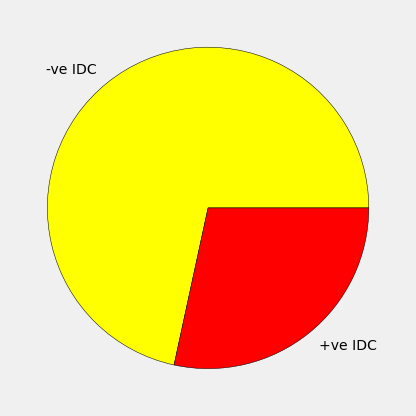

In [36]:
plt.style.use("fivethirtyeight")
slices = [class0_n,class1_n]
labels = ['-ve IDC','+ve IDC']
colors = ['yellow','red']
fig = plt.figure(figsize =(8, 6))
plt.pie(slices, labels=labels, colors=colors, wedgeprops={'edgecolor':'black'})
plt.tight_layout()
plt.show()

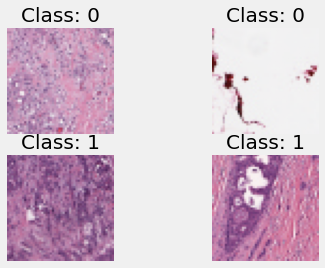

In [38]:
class0_images = os.listdir("datasets/idc/training/0")
class1_images = os.listdir("datasets/idc/training/1")
pic_index = 50
next_class0 = class0_images[pic_index-2:pic_index]
next_class1 = class1_images[pic_index-2:pic_index]

plt.figure()
for i, img_path in enumerate(next_class0):
    plt.subplot(2,2,i+1)
    img = mpimg.imread("datasets/idc/training/0/"+img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.title("Class: 0")

for i, img_path in enumerate(next_class1,start=2):
    plt.subplot(2,2,i+1)
    img = mpimg.imread("datasets/idc/training/1/"+img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.title("Class: 1")
plt.show()

# Training

In [ ]:
# initialize our CancerNet model and compile it
width=48
height=48
depth=3
classes=2
inputShape = (height, width, depth)
chanDim = -1

# if we are using "channels first", update the input shape
# and channels dimension
if K.image_data_format() == "channels_first":
  inputShape = (depth, height, width)
  chanDim = 1

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', padding="same", input_shape=inputShape),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The third convolution
    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(axis=chanDim),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('0') and 1 for the other ('1')
    tf.keras.layers.Dense(classes, activation='softmax')
])

In [17]:
# set the matplotlib backend so figures can be saved in the background
matplotlib.use("Agg")

#construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())
# initialize our number of epochs, initial learning rate, and batch
# size

NUM_EPOCHS = 40
INIT_LR = 1e-2
BS = 32

# determine the total number of image paths in training, validation,
# and testing directories
trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

# calculate the total number of training images in each class and
# initialize a dictionary to store the class weights
trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]


# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS
)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS
)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS
)

# initialize our CancerNet model and compile it

opt = Adagrad(learning_rate=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model_1.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"]
)


Found 255718 images belonging to 2 classes.
Found 42638 images belonging to 2 classes.
Found 99850 images belonging to 2 classes.


In [ ]:
# fit the model
H = model_1.fit(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	class_weight=classWeight,
	epochs=10
)

# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model_1.predict(x=testGen, steps=(totalTest // BS) + 1)

#for each image in the testing set we need to find the index of the
#label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

Epoch 1/10
7989/7989 [==============================] - 528s 64ms/step - loss: 0.5957 - accuracy: 0.8214 - val_loss: 0.4191 - val_accuracy: 0.8314
Epoch 2/10
7989/7989 [==============================] - 360s 45ms/step - loss: 0.5576 - accuracy: 0.8315 - val_loss: 0.4274 - val_accuracy: 0.8222
Epoch 3/10
7989/7989 [==============================] - 355s 44ms/step - loss: 0.5503 - accuracy: 0.8340 - val_loss: 0.4043 - val_accuracy: 0.8335
Epoch 4/10
7989/7989 [==============================] - 357s 45ms/step - loss: 0.5456 - accuracy: 0.8349 - val_loss: 0.4072 - val_accuracy: 0.8301
Epoch 5/10
7989/7989 [==============================] - 363s 45ms/step - loss: 0.5439 - accuracy: 0.8355 - val_loss: 0.4052 - val_accuracy: 0.8312
Epoch 6/10
7989/7989 [==============================] - 354s 44ms/step - loss: 0.5404 - accuracy: 0.8367 - val_loss: 0.4091 - val_accuracy: 0.8284
Epoch 7/10
7989/7989 [==============================] - 353s 44ms/step - loss: 0.5398 - accuracy: 0.8375 - val_loss: 0

In [ ]:
model_1.save("model.h5")

In [ ]:
drive.mount('Drive')

Mounted at Drive


[[59374 12153]
 [ 5232 23144]]
acc: 0.8260
sensitivity: 0.8301
specificity: 0.8156


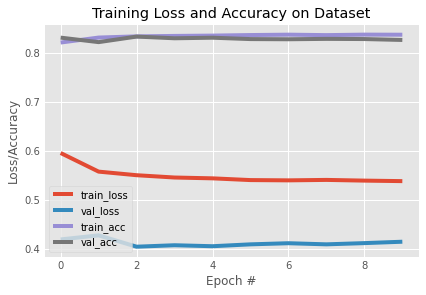

In [ ]:
#compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

#show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

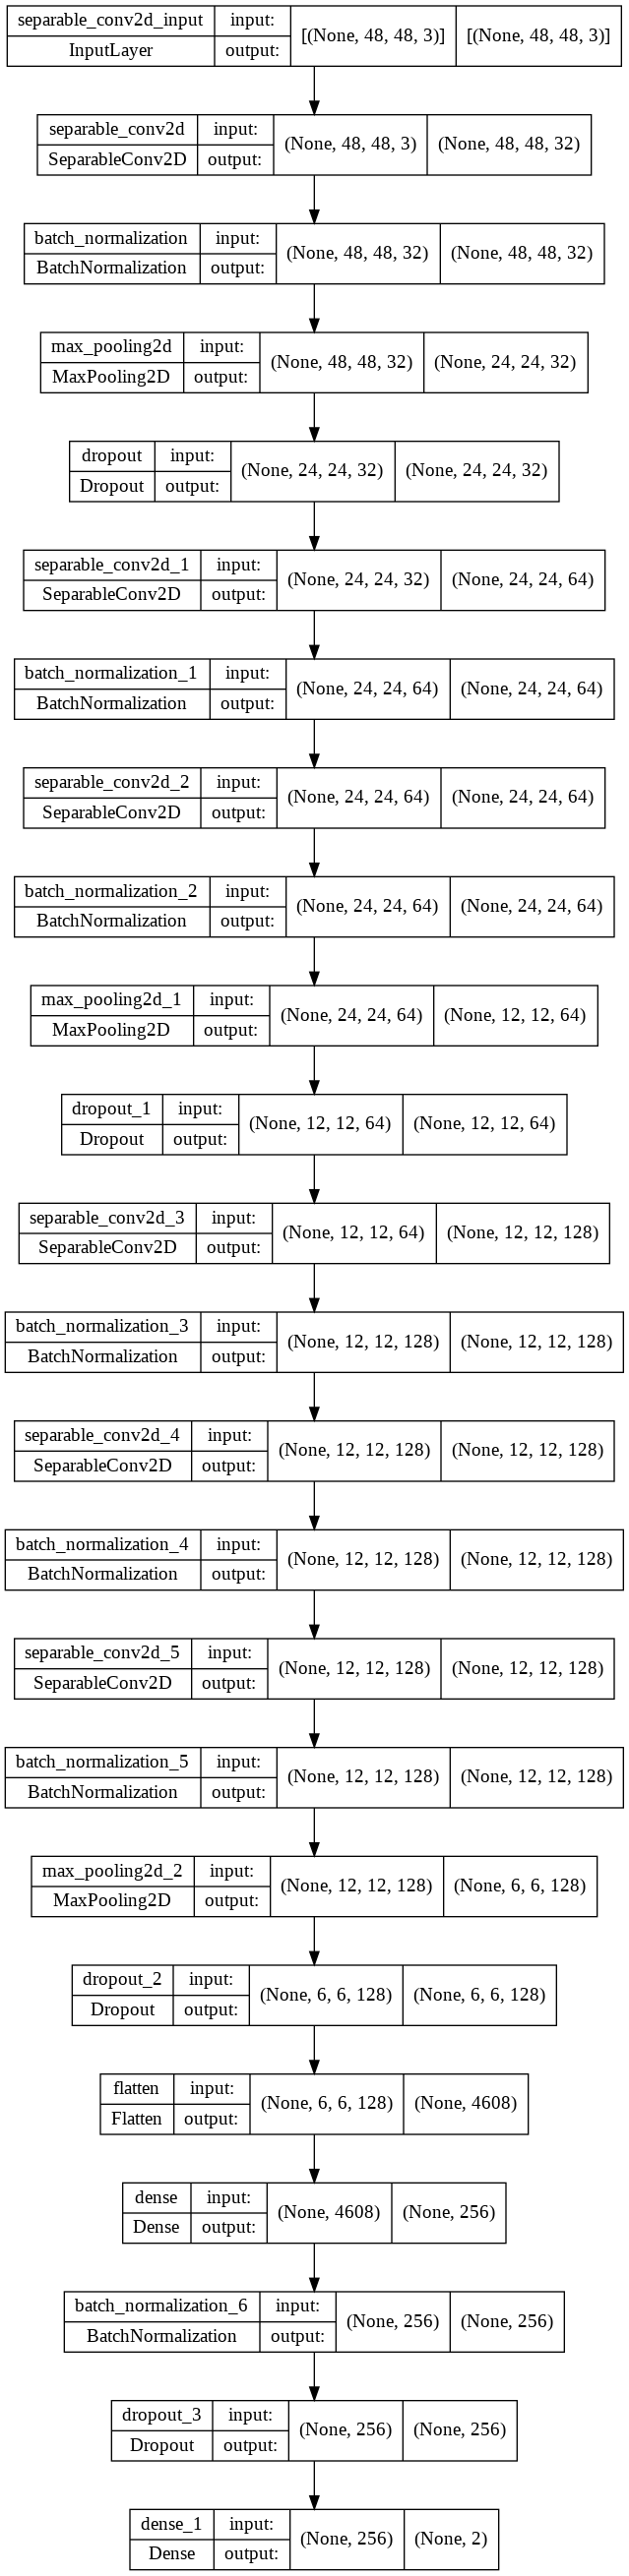

In [ ]:
tf.keras.utils.plot_model(model_1, to_file="model_1.png", show_shapes=True)

In [ ]:
drive.flush_and_unmount()

In [5]:
model = tf.keras.models.load_model(os.path.join('drive','MyDrive','model.h5'))

Saving Case_1-01.png to Case_1-01 (2).png

Image_Name: Case_1-01.png


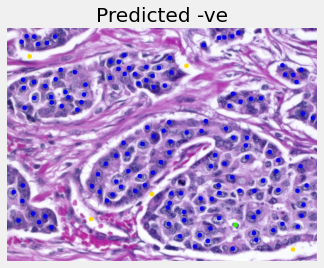

In [40]:
uploaded = files.upload()
print()
for fn in uploaded.keys():
    # predicting images
    path = fn
    img = load_img(path, target_size=(48, 48))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    class_names = ["-ve","+ve"]
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print("Image_Name:",fn)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('Off')
    plt.title(F"Predicted {class_names[np.argmax(classes)]}")
    plt.show()
    print()